## Dissertation Project - News Summary Dissertation [100 marks]

### Motivation 

> 1. Provide tools for anyone needing to speed up their research process
> 2. Providing ways for user to quickly determine whether a piece of research is beneficial for their specific search terms




In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Toggle code"></form>''')

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import random
from tqdm.notebook import tqdm
import ipywidgets as widgets
import fitz

import numpy as np 
import pandas as pd
import math
import time

import json
import pickle
import _pickle as pickle

import transformers

DATASET = "./Dataset/"

Detect which device (CPU/GPU) to use.

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Overview

Summarisation model
> 1. Dataset preprocessing
> 2. Dataloader
> 3. RNN model definition
> 4. Model training
> 5. Model prediction evaluation
> 6. Dataset Exploration
> 7. Dataset modification/Data Augmentation
> 8. Model improvement
> 9. Model finalisation and evaluation

Paper querying
> 1. Attention on query (Return usefulness percentage
> 2. Evaluate performance


# Data preprocessing

In [4]:
# # Comment this block if dataset is reorganised
# DATA_DIR = "SSN/papers.SSN.jsonl"
# dataset_path = DATASET+DATA_DIR
# with open(dataset_path) as f:
#     lines = f.read().splitlines()
# df_inter = pd.DataFrame(lines)
# df_inter.columns = ['json_element']
# df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
# df_final.to_json("./Dataset/SSN/SSN_Dataset.json")
# df_final

In [5]:
# for i,summary in df_final.iterrows():
#     temp = summary["abstract"]
#     print(type(summary["abstract"]))
#     break

In [6]:
# #Comment this block if dataset is shortened
# DATA_DIR = "SSN/SSN_Dataset.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df

In [7]:
# df.iloc[140794]["section_names"]

Function to return index for conclusion section

In [8]:
# def trim_index(row):
#     return [row.index(x)+1 for x in row if x.startswith('conclusion') or x.startswith("summar")]

In [9]:
# def trim_text(text, index):
#     return text[0:index]

In [10]:
# # Comment this block if dataset is shortened
# # Trim text after conclusion
# indexes = []
# for i, row in df.iterrows():
#     section = row["section_names"]
#     #print(section)
#     index = trim_index(section)
#     #print(index)
#     if not index:
#         indexes.append(i)
#     # if section can be filtered
#     else:
#         index = index[0]
#         abstract = row["abstract"]
#         text = row["text"]
#         section = row["section_names"]
#         df.at[i, "section_names"] = trim_text(section, index)
#         df.at[i, "abstract"] = trim_text(abstract, index)
#         df.at[i, "text"] = trim_text(text, index)
# # dropping rows in dataframe that can't easily filter out reference section
# print(len(indexes))
# df.drop(indexes, inplace=True)
# df.to_json("./Dataset/SSN/SSN_Dataset_Short.json")

35% of paper will be removed from the dataset due to it not having conclusion(s) and summary(ies) in their section titles, making it difficult to filter out the reference and appendix text

In [11]:
# DATA_DIR = "SSN/SSN_Dataset_Short.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df.reset_index(drop=True, inplace=True)
# df

See diversity in papers, select only computer science

In [12]:
# plot_points = df['domain'].value_counts()
# plot_points

In [13]:
# df = df.loc[df['domain'].isin([['Computer science']])]
# df.to_json("./Dataset/SSN/SSN_Dataset_CompSci_Short.json")
# df

In [14]:
# DATA_DIR = "cnn_dailymail/train.csv"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_csv(dataset_path)
# df = df.rename(columns={'article': 'text', 'highlights': 'abstract'})
# df

In [15]:
# DATA_DIR = "SSN/SSN_Dataset_CompSci_Short.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df.reset_index(drop=True, inplace=True)
# df

In [16]:
# summary_df = df[["abstract", "text"]]
# summary_df

Check if any columns contain empty values

In [17]:
# summary_df.isnull().any()

\'hi\' \ is used for space <br>
random space, which is used for reference [15] quote box <br>
sec ref is hyperlink to a section <br>
fig ref is hyperlink to a figure <br>
inlineform <br>
displayform are both symbols, both contains numbers in string <br>
remove all forms and remove all symbols but keep numbers <br>

In [18]:
# def contain_let(string):
#     return any(char.isalpha() for char in string)

In [19]:
# def contain_num(string):
#     return any(char.isdigit() for char in string)

In [20]:
# def contain_special(string, allowed):
#     '''
#     allowed is a list containing allowed symbols to pass detection
#     '''
#     return any(not(char.isalpha() or char.isdigit()) and (char not in allowed) for char in string)

In [21]:
# def cleanLine(line, text=True, aug=False):
#     "text parameter is to indicate whether the line is from text or abstract"
#     symbols = ["'", "’"]
#     stop_words = list(ENGLISH_STOP_WORDS)
    
#     clean_line = line.lower()

#     # fix apostrophes in line by removing apostrophe with no following alphabet character
#     clean_line = clean_line.replace("'", " ")
#     clean_line = clean_line.replace(",", " ")
# #     # remove apostrophe if last character is apostrophe
# #     if clean_line and (clean_line[-1] == "'"):
# #         clean_line = clean_line[0:len(clean_line)-1]
# #     # fix apostrophes in line by removing space before single quote
# #     clean_line = clean_line.replace(" '", "'")


#     # clean line = clean line remove forms
#     words = clean_line.split()
#     #  remove forms, words with special characters inside
#     # if contain letter and number
#     # if contain special character not in allowed symbols and removing punctuations
#     # then remove
#     words = [x.replace(x, "") if (contain_let(x) and contain_num(x))
#              or contain_special(x, symbols)
#              else x for x in words]

#     # remove empty strings
#     words = filter(None, words)

#     # stop words from sklearn, remove stop words
#     if text:
#         words = [x for x in words if not x in stop_words]
#     # remove from line randomly
#     if text and aug:
#         choices = random.choices(words, k=math.floor(len(line)*0.2))
#         words.remove(choices)
        
#      # combine the items into 1 string
#     clean_line = ' '.join(words)

    

#     return clean_line

In [22]:
# def concatParagraph(paragraph, text=True):
#     clean_paragraph = ""
#     for line in paragraph:
#         lines = cleanLine(line)
#         clean_paragraph += cleanLine(lines, text) + " "
#         #print(clean_paragraph)
        
#     return(clean_paragraph.strip())

In [23]:
# def concatPaper(paper, text=True):
#     clean_paper = ""
#     for paragraph in paper:
#         clean_paper += concatParagraph(paragraph, text) + " "
#     return(clean_paper.strip())

In [24]:
# import time
# interval = 0.0001
# aug_chance = 0.5
# for i, row in tqdm(summary_df.iterrows(), total=summary_df.shape[0]):
#     abstract = row["abstract"]
#     paper = row["text"]
    
# #     summary_df.at[i, "abstract"] = concatParagraph(abstract, text=False)
# #     summary_df.at[i, "text"] = concatPaper(paper)
#     if random.random() > aug_chance:
#         row_val = cleanLine(paper, text=True, aug=True)
#         new_row = pd.Series([abstract, row_val], index=summary_df.columns)
#         df_summary = df_summary.append(row1,ignore_index=True) 
#         df_summary
#     summary_df.at[i, "abstract"] = cleanLine(abstract, text=True)
#     summary_df.at[i, "text"] = cleanLine(paper)
#     time.sleep(interval)

In [25]:
# summary_df.to_csv("./Dataset/cnn_dailymail/cleaned_cnn_train.csv")
# summary_df

In [3]:
DATA_DIR = "SSN\SSN_Dataset_CompSci_Short_Clean_HalfStop_170_Filter.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
#df = df[["source_text", "target_text"]]
# df = df.rename(columns={'text': 'source_text', 'abstract': 'target_text'})
# df['source_text'] = "summarize: " + df['source_text']
df

,target_text,source_text
0,tracking developments highly dynamic data tech...,summarize: ubiquity online resources massive g...
1,extracting multi scale information key semanti...,summarize: medical image segmentation challeng...
2,scarcity richly annotated medical images limit...,summarize: deaths attributed pneumonia reporte...
3,paper introduce novel concept densely connecte...,summarize: language modeling key task natural ...
4,known determined adversary fool neural network...,summarize: recent years neural networks shown ...
...,...,...
4049,open domain dialogue intelligent agents exhibi...,summarize: arguably key goals ai ultimate goal...
4050,ubiquitous diffusion social networks images do...,summarize: era social networks images dominant...
4051,paper introduces modification phase transform ...,summarize: cocktail party effect consists abil...
4052,present neural encoder decoder model convert i...,summarize: optical character recognition ocr c...


In [16]:
# t_max = 0
# a_max = 0
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     t_len = len(tokeniser(row['source_text'])['input_ids'])
#     a_len = len(tokeniser(row['target_text'])['input_ids'])
#     if t_len > t_max:
#         t_max = t_len
#     if a_len > a_max:
#         a_max = a_len
# print("t_max: ",t_max)
# print("a_max: ", a_max)

  0%|          | 0/4054 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1562 > 512). Running this sequence through the model will result in indexing errors


t_max:  2100
a_max:  193


In [31]:
len(indexes)

6096

In [32]:
df.drop(indexes, inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_json(DATASET+"SSN\SSN_Dataset_CompSci_Short_Clean_HalfStop_170_Filter.json")
df

,target_text,source_text
0,tracking developments highly dynamic data tech...,summarize: ubiquity online resources massive g...
1,extracting multi scale information key semanti...,summarize: medical image segmentation challeng...
2,scarcity richly annotated medical images limit...,summarize: deaths attributed pneumonia reporte...
3,paper introduce novel concept densely connecte...,summarize: language modeling key task natural ...
4,known determined adversary fool neural network...,summarize: recent years neural networks shown ...
...,...,...
4049,open domain dialogue intelligent agents exhibi...,summarize: arguably key goals ai ultimate goal...
4050,ubiquitous diffusion social networks images do...,summarize: era social networks images dominant...
4051,paper introduces modification phase transform ...,summarize: cocktail party effect consists abil...
4052,present neural encoder decoder model convert i...,summarize: optical character recognition ocr c...


In [4]:
# ABSTRACT_MAX = 170
# TEXT_MAX = 3050
ABSTRACT_MAX = 200
TEXT_MAX = 2000

In [15]:
from transformers import AutoTokenizer,BertTokenizer
tokeniser = AutoTokenizer.from_pretrained('t5-small') 
# takes into account of apostrophe

In [113]:
# train tokeniser
corpus = []
for i, row in df.iterrows():
    corpus.append([row["text"]])
tokeniser.train_new_from_iterator(corpus, 10000)

DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=3186, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [32]:
# rows = []
# t_max= 2524
# a_max=  118
# t_min=  668
# a_min=  39
# for i, row in df.iterrows():
#     t_word = len(row["text"].split())
#     a_word = len(row["abstract"].split())
#     if ((t_word > t_max or t_word < t_min) or (a_word > a_max or a_word < a_min)):
#         rows.append(i)

# df.drop(rows, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.to_json(DATASET+"SSN/SSN_Dataset_CompSci_Short_Clean_HalfStop_180.json")
# df

In [33]:
# class Vocabulary(object):
#     """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
#     def __init__(self):
#         # intially, set both the IDs and words to dictionaries with special tokens
#         self.word2idx = {'<pad>': 0,'<start>': 1, '<end>': 2, '<unk>': 3}
#         self.idx2word = {0: '<pad>',1: '<start>', 2: '<end>', 3: '<unk>'}
#         self.idx = 4

#     def add_word(self, word):
#         # if the word does not already exist in the dictionary, add it
#         if not word in self.word2idx:
#             # this will convert each word to index and index to word as you saw in the tutorials
#             self.word2idx[word] = self.idx
#             self.idx2word[self.idx] = word
#             # increment the ID for the next word
#             self.idx += 1

#     def __call__(self, word):
#         # if we try to access a word not in the dictionary, return the id for <unk>
#         if not word in self.word2idx:
#             return self.word2idx['<unk>']
#         return self.word2idx[word]
    
#     ## added function for utility
#     def get_word(self,index):
#         # this returns the word when given an index
#         return self.idx2word[index]

#     def __len__(self):
#         return len(self.word2idx)


In [34]:
# def build_vocab(data, freq):
#     """ 
#     Parses training set token file captions and builds a Vocabulary object and dataframe for 
#     the image and caption data

#     Returns:
#         vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
#     """
#     MIN_FREQUENCY = freq
#     word_mapping = Counter()

#     # for index in df.index:
#     for text in tqdm(data):
#         for word in text.split():
#             #print(word)
#             if word in word_mapping:
#                 word_mapping[word] += 1
#             else:
#                 word_mapping[word] = 1

#     # create a vocab instance
#     vocab = Vocabulary()

#     # add the words to the vocabulary
#     for word in word_mapping:
#         if word_mapping[word] > MIN_FREQUENCY:
#             vocab.add_word(word)

#     return vocab


Convert DF to text

In [35]:
# text_txt = df['text']
# text_txt.to_csv("text_cnn.txt", header=False,index=False)
# abstract_txt = df['abstract']
# abstract_txt.to_csv("abstract_cnn.txt", header=False,index=False)

# # write to file. 

In [36]:
# vocab_model = fasttext.train_unsupervised('text_NoStop.txt', minn=2, epoch=10)
# vocab_model.save_model("fastText_NoStop.bin")

In [37]:
# abstract_vocab = build_vocab(df["abstract"], 0)
# text_vocab = build_vocab(df["text"], 0)
# print("abstract vocab", len(abstract_vocab))
# print("text vocab", len(text_vocab))
# # def save_object(objects, filename):
# #     with open(filename, 'wb') as outp:  # Overwrites any existing file.
# #         pickle.dump(objects, outp, -1)
# # vocabs = [abstract_vocab, text_vocab]
# # save_object(vocabs, 'SSNvocabs180_0F2.pkl')

In [38]:
# with open('SSNvocabs180_0F2.pkl', 'rb') as inp:
#     abstract_vocab, text_vocab = pickle.load(inp)
# print("abstract vocab", len(abstract_vocab))
# print("text vocab", len(text_vocab))

In [39]:
# def tokenise(vocab, text, max_len, target=True):
#     word_ids = []
#     if target:
#         word_ids = [vocab("<start>")]
#     for word in text.split():
#         word_ids.append(vocab(word))
#     word_ids.append(vocab("<end>"))
#     while len(word_ids) < max_len:
#             word_ids.append(vocab("<pad>"))
#     return word_ids

In [5]:
class SSNDataset(Dataset):
    def __init__(self, df, tokeniser):

        self.df = df
#         self.a_vocab = a_vocab
#         self.t_vocab = t_vocab
        self.abstract_max_len = ABSTRACT_MAX
        self.text_max_len = TEXT_MAX
        self.tokeniser = tokeniser

    def __getitem__(self, index):
        # return word_id
        prefix = "summarize: "
        abstract = self.df.iloc[index]["target_text"]
        text = self.df.iloc[index]["source_text"]
        
        text_id = self.tokeniser(text, max_length=self.text_max_len,padding='max_length')

        abstract_id = self.tokeniser(abstract, max_length=self.abstract_max_len, padding='max_length')

        
#         a_word_ids = tokenise(self.a_vocab, abstract, self.abstract_max_len, target=True)
#         t_word_ids = tokenise(self.t_vocab, text, self.text_max_len, target=True)

#         a_length = len(a_word_ids)
#         t_length = len(t_word_ids)
        text_id["labels"] = abstract_id["input_ids"]
        return text_id#torch.tensor(a_word_ids), torch.tensor(t_word_ids)#a_word_ids, t_word_ids

    def __len__(self):
        return len(self.df)


In [43]:
def text_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple of 2 word ids
        - abstract id
        - text id
    Returns:
        abstract list ids
        text list ids
    """
    dictionary = {}

    labels = [row['labels'] for row in data]
    texts = [row['input_ids'] for row in data]
    masks = [row['attention_mask'] for row in data]
    
    
    dictionary['input_ids'] = torch.tensor(texts)
    dictionary['labels'] = torch.tensor(labels)
    dictionary['attention_mask'] = torch.tensor(masks)

    return dictionary
    
    abstracts, texts = zip(*data)
#     abstract_list = []
#     text_list = []
#     for i in range(len(texts)):
#         text_list.append(torch.tensor(texts[i]))
#         abstract_list.append(torch.tensor(abstracts[i]))


#     abstracts = torch.tensor(abstracts)
#     texts = torch.tensor(texts)
#     abstracts = [ torch.Tensor(abstract).to(device) for abstract in abstracts ]
# if batch size is 1 then use [0]
#     abstracts = torch.stack(tuple(abstract_list), 0)
#     texts = torch.stack(tuple(text_list), 0)
    #abstracts = abstracts.unsqueeze(0)
    abstracts = torch.stack(abstracts, 0)
    texts = torch.stack(texts, 0)
    #texts = texts.unsqueeze(0)

    return abstracts, texts


# Dataloader

Split dataset

In [5]:
train_data, test_data = train_test_split(df, random_state=seed, train_size = 0.7)
train_data, valid_data = train_test_split(train_data, random_state=seed, train_size=0.8)

In [9]:
train_set = SSNDataset(train_data, tokeniser)
valid_set = SSNDataset(test_data,  tokeniser)
#test_set = SSNDataset(test_data, tokeniser)

In [84]:
from transformers import Seq2SeqTrainingArguments
batch_size = 2
model_name = 't5-small'.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=100,
    predict_with_generate=True,
    save_strategy="epoch",
    fp16=True,
    logging_steps=1,

)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [87]:
from transformers import Trainer,AutoModelForSeq2SeqLM, T5Config, T5Model, AutoConfig,AutoTokenizer

#tokeniser = AutoTokenizer.from_pretrained("google/t5-efficient-tiny")
#tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-tiny")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
#model.resize_token_embeddings(len(tokeniser))
# checkpoint = "t5-small"
# config = AutoConfig.from_pretrained(checkpoint)
# model = AutoModelForSeq2SeqLM.from_config(config)
# model_config = model.config.to_dict()
# print(model_config.keys())
# model_config["num_heads"] = 2
# model_config["d_model"] = 256
# model_config["d_ff"] = 256
# model_config["d_kv"] = 4
# model_config["num_decoder_layers"] = 2
# print(model_config["num_decoder_layers"])
# config = T5Config(**model_config)
# model = AutoModelForSeq2SeqLM.from_config(config)
# model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
# model_config = model.config.to_dict()
# print(model_config.keys())
# model_config["num_heads"] = 2
# model_config["d_model"] = 256
# model_config["d_ff"] = 256
# model_config["d_kv"] = 4
# model_config["num_decoder_layers"] = 2
# print(model_config["num_decoder_layers"])
# config = T5Config(**model_config)
# model = AutoModelForSeq2SeqLM.from_config(config)
# model.resize_token_embeddings(len(tokeniser))
#model = AutoModelForSeq2SeqLM.from_pretrained('t5-small', config = config)
trainer = Trainer(
    model=model,
    tokenizer=tokeniser,
    args=args,# the instantiated 🤗 Transformers model to be trained
    train_dataset=train_set,   # training dataset
    eval_dataset=valid_set,      # evaluation dataset
    data_collator=text_collate_fn    # problem with removing unwanted columns by transformers.Trainer code. Doesn't really work, is it a bug?
)
trainer.train()


loading configuration file https://huggingface.co/t5-small/resolve/main/config.json from cache at C:\Users\tomwu/.cache\huggingface\transformers\fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.d67b370cd9d75f81ad4eb421ee7b8db09e0b6a6c693b8c2b423af5d7bcac6205
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 8.00 GiB total capacity; 7.26 GiB already allocated; 0 bytes free; 7.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [159]:
trainer.save_model("./" + 'model')

In [6]:
from simplet5 import SimpleT5
model = SimpleT5()
model.from_pretrained(model_type="t5", model_name="t5-small")

C:\Users\tomwu\AppData\Roaming\Python\Python39\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Global seed set to 42


In [20]:
model.train(train_df=train_data,
        eval_df=valid_data,
        source_max_token_len=TEXT_MAX,
        target_max_token_len=ABSTRACT_MAX,
        batch_size=2,
        max_epochs=2,
        use_gpu=True,)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\tomwu\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
C:\Users\tomwu\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [32]:
dir(model.model)
from transformers import T5Config
# model_config = model.model.config.to_dict()
# for k, v in model_config.items():
#     print(k, v)
model_config = model.model.config.to_dict()
model_config["num_heads"] = 4
config = T5Config(**model_config)
# model = AutoModelForSeq2SeqLM.from_config(config)
model.model.config = config
model.model.config

T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 4,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_beams": 4,
      "prefix": "translate English to German: "
    },
    "translation_en_to_fr": {
      "early_stoppin

In [19]:
inputs = valid_data.at[7,"source_text"]
print(inputs)
print("")
print(valid_data.at[7,"target_text"])
model.device = "cpu"
model.predict(inputs)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [170]:
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to(device)
inputs = ["summarize: " + train_data.at[1,"text"]]
print(inputs)
print("")
print(train_data.at[1,"abstract"])
inputs = tokeniser(inputs, max_length=TEXT_MAX, return_tensors="pt").to(device)
output = model.generate(**inputs, num_beams=8, max_length=130)
print(output)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=False)[0]
print(decoded_output)
# preds, labels= trainer.predict()
# preds_tokens = preds.argmax(axis=2)
# preds_tokens

['summarize: s accused making fashion faux pas prime minister deaf yesterday david cameron seen pair beige loafers wore holiday mr cameron lanzarote family got shoes high street store aldo took portugal david cameron samantha yes s wearing shoes david cameron samantha portugal year debuted beige loafers yesterday teamed casual navy blue shirt beige shorts trip teguise centre island wife fashion consultant mrs cameron trumped husband style stakes wearing elegant black maxi dress emerald green couple children nancy arthur florence spending days island restored century farmhouse away main prime minister sported socks smart black work shoes memorable holiday look couple wear matching trainers holiday granada spain 2011 retreat styled indonesian includes carved buddha statues yoga hall swimming pool hot tub area hammocks ideal prime minister reputedly taste mr cameron previously ridiculed holiday attire wearing smart black work shoes socks garish floral david cameron wife samantha stop coff

In [ ]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, collate_fn=text_collate_fn) # num_worker can't be 2+ as the time it 
                                                                 # takes to build iter is much longer
valid_loader = DataLoader(valid_set, batch_size=8, shuffle=True, collate_fn=text_collate_fn)


In [276]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn)

In [ ]:
batch_size = 8
model_name = 't5-small'.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
)

In [42]:
# all_set = SSNDataset(df, abstract_vocab, text_vocab)
# all_loader = DataLoader(all_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn)
# abstracts = []
# texts = []
# for i, (abstract, text) in tqdm(enumerate(all_loader), total=len(all_loader)):
#     a_size = list(abstract.size())[1]

#     t_size = list(text.size())[1]
#     abstracts.append(a_size)
#     texts.append(t_size)
# numbers = list(range(len(all_loader)))

In [43]:
# from statistics import mean
# print("max length for abstract: ",max(abstracts))
# print("max length for text: ",max(texts))
# print("min length for abstract: ",min(abstracts))
# print("min length for text: ",min(texts))
# print("average length for abstract: ",math.floor(mean(abstracts)))
# print("average length for text: ",math.floor(mean(texts)))

In [44]:
# print(math.floor(np.percentile(texts, 50)))
# print(math.floor(np.percentile(abstracts, 50)))
# print(math.floor(np.percentile(texts, 1)))
# print(math.floor(np.percentile(abstracts, 1)))

In [45]:
# a_perc = []
# t_perc = []
# for i in range(100):
#     i +=1
#     a_perc.append(np.percentile(abstracts, i))
#     t_perc.append(np.percentile(texts,i))

In [46]:
# plt.scatter(range(len(a_perc)),a_perc)
# plt.show()

In [47]:
# plt.scatter(range(len(t_perc)), t_perc)
# plt.show()

# RNN Model definition

In [48]:
# from gensim.models import Word2Vec
# vec = Word2Vec(sentences="text_cnn.txt", vector_size=300, window=5, min_count=2)

In [49]:
# text_vocab = vec.wv.key_to_index
# text_vocab

In [118]:
# def create_tgt_mask(size):
#     # Generates a squeare matrix where the each row allows one word more to be seen
#     mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
#     mask = mask.float()
#     mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
#     mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
#     return mask.to(device)

In [277]:
def create_mask(data, pad_idx):
    return (data == pad_idx)

In [278]:
class EncoderNet(nn.Module):
    def __init__(self, text_vocab, pad_idx, embed_dim, hidden_size, nheads, n_layers, max_text_len, 
                 dropout):
        super(EncoderNet, self).__init__()
        self.pad_idx = pad_idx
        # embedding layers
        self.enc_embedding = nn.Embedding(text_vocab, embed_dim)
        # positional encoding layer
        self.enc_pe = PositionalEncoding(embed_dim, max_len = max_text_len)
        # encoder layers
        enc_layer = nn.TransformerEncoderLayer(embed_dim, nheads, hidden_size, dropout)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers = n_layers)
    
    def forward(self, x):
        mask = create_mask(x, self.pad_idx)
        enc_embed = self.enc_embedding(x).permute(1, 0, 2)
        enc_pe = self.enc_pe(enc_embed)
        memory = self.encoder(enc_pe, src_key_padding_mask=mask)
        return memory

In [279]:
class DecoderNet(nn.Module):
    def __init__(self, abstract_vocab, pad_idx, embed_dim, hidden_size, nheads, n_layers, max_abs_len, 
                 dropout):
        super(DecoderNet, self).__init__()
        self.pad_idx = pad_idx
        # embedding layers
        self.dec_embedding = nn.Embedding(abstract_vocab, embed_dim)
        # positional encoding layer
        self.dec_pe = PositionalEncoding(embed_dim, max_len = max_abs_len)
        # decoder layers
        dec_layer = nn.TransformerDecoderLayer(embed_dim, nheads, hidden_size, dropout)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers = n_layers)
    
    def forward(self, x, enc_output):
        #target_mask = create_tgt_mask(x.shape[1])
        mask = create_mask(x, self.pad_idx)

        dec_embed = self.dec_embedding(x).permute(1, 0, 2)
        dec_pe = self.dec_pe(dec_embed)
        dec_out = self.decoder(dec_pe, enc_output, tgt_key_padding_mask=mask)
        return dec_out

In [280]:
class TransformerNet(nn.Module):
  def __init__(self, text_vocab, abstract_vocab, pad_idx, embed_dim, hidden_size, nheads, n_layers, 
               max_text_len, max_abs_len, dropout):
    super(TransformerNet, self).__init__()
    self.EncoderNet = EncoderNet(text_vocab, pad_idx, embed_dim, hidden_size, nheads, n_layers, 
                                 max_text_len, dropout)
    self.DecoderNet = DecoderNet(abstract_vocab, pad_idx, embed_dim, hidden_size, nheads, n_layers, 
                                 max_abs_len, dropout)
    # final dense layer
    self.fc = nn.Linear(embed_dim, abstract_vocab)
    #self.log_softmax = nn.LogSoftmax()

  def forward(self, text, abstract):

    enc_output = self.EncoderNet(text)

    dec_output = self.DecoderNet(abstract, enc_output)
    
    output = self.fc(dec_output)
    return output #self.log_softmax(output)

In [281]:
# See Pytorch tutorial for details
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [282]:
def get_model(text_size,abstract_size,pad_idx, embed_size, hid_dim, 
                       n_head, n_layer, TEXT_MAX, ABSTRACT_MAX, dropout, path=None):
    
    model = TransformerNet(text_size,abstract_size,pad_idx, embed_size, hid_dim, 
                       n_head, n_layer, TEXT_MAX, ABSTRACT_MAX, dropout).to(device)
    if path == None:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        return model
    else:
        model.load_state_dict(torch.load(best_path))
        return model

In [283]:
text_size = len(text_vocab)
abstract_size = len(abstract_vocab)
pad_idx = 0
embed_size = 128  # embedding dimension
hid_dim = 100  # dimension of the feedforward network model in ``nn.TransformerEncoder``
n_head = 2
n_layer =1  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
dropout = 0.1  # dropout probability

In [284]:
best_path = "trans_SSN_256_256_Batch_8_4H3lr0.0001.pth"
# model = TransformerNet(text_size,abstract_size,pad_idx, embed_size, hid_dim, 
#                        n_head, n_layer, TEXT_MAX, ABSTRACT_MAX, dropout, best_path).to(device)

model = get_model(text_size,abstract_size,pad_idx, embed_size, hid_dim, 
                       n_head, n_layer, TEXT_MAX, ABSTRACT_MAX, dropout).to(device)

model

TransformerNet(
  (EncoderNet): EncoderNet(
    (enc_embedding): Embedding(14210, 128)
    (enc_pe): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=100, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=100, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (DecoderNet): DecoderNet(
    (dec_embedding): Embedding(3752, 128)
    (dec_pe): Positio

In [285]:
# for i, (abstract, text) in tqdm(enumerate(train_loader), total=len(train_loader)):
#     # send batch data to device
#     print("i", i)
#     src = text.to(device)
#     trg = abstract.to(device)
    
    
# #     src_mask, trg_mask = create_masks(src, trg)
# #     src_mask.to(device)
# #     trg_mask.to(device)
    
#     preds = model(src, trg)
#     print(preds.shape)
#     # this gives topk, then select the top1 result, then review it as a list
#     # then select the last item, this would be the highest prob
#     # only work in inference as this requires no batch
#     token = preds.topk(1)[1].view(-1)[-1].item()
#     print(token)
#     print(abstract_vocab.get_word(token))
    
    

# Tasks
~~1 - Complete model definition~~ <br>
~~2 - fix word vocab~~ <br>
~~3 - Define Attention model and combine with Decoder~~ <br>
    ~~1 - Adjust to allow for batch ~~<br>
4 - trace through program to see where it starts to have the same tensor <br>
~~5 - use mask to hide paddings~~ switch on off to see difference<br>
~~6 - Switch from GRU to LSTM~~<br>
~~7 - Add training script to train ~~<br>
 

# Model training

In [288]:
def train(train_loader, valid_loader, model):
    lr = 0.001
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx) # ignore pad
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # learning rate also affects overfitting
    #scheduler = ReduceLROnPlateau(optimizer, 'min')
    epoch_size = 20
    loss_epoch = []
    loss_accuracy = []
    eval_loss_epoch = []
    eval_accuracy = []
    best_loss = 1000
    
    for epoch in range(1,epoch_size+1):
        
        model.train()
        loss_batch = []
        batch_acc = []
        for i, (abstract, text) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # send batch data to device
            
            abstract = abstract.to(device)
            text = text.to(device)
            tar_inp = abstract[:, :-1]
            tar_real = abstract[:, 1:]
            
            
#             print(text)
#             print(abstract)
            outputs = model(text, abstract=tar_inp).to(device).permute(1,2,0)
            #print(outputs)
            #decode(outputs, abstract)
            loss = criterion(outputs, tar_real)
            #batch_acc.append(get_accuracy(outputs, abstract))
            #print(loss.item())
            
            # Optimise
            del abstract
            del text
            del outputs

            loss_batch.append(loss.item())
            optimizer.zero_grad()
            loss.backward()

            #plot_grad_flow(model.named_parameters())
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            del loss
            torch.cuda.empty_cache()
            
            
        #return model
            #print(loss.item())
        current_loss = np.average(loss_batch)
        current_acc = np.average(batch_acc)
        loss_epoch.append(current_loss)
        loss_accuracy.append(current_acc)

        print('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.4f}'
            .format(epoch, epoch_size, current_loss, current_acc))

        eval_loss_batch = []
        eval_batch_acc = []

        model.eval()
        with torch.no_grad():
            for j, (abstract, text) in enumerate(valid_loader):
                abstract = abstract.to(device)
                text = text.to(device)
                
                scores = model(text, abstract=abstract).to(device).permute(1,2,0)
                #decode(scores, abstract)
                eval_loss = criterion(scores, abstract)
                
                #print(eval_loss.item())
                eval_loss_batch.append(eval_loss.item())
                eval_batch_acc.append(get_accuracy(scores, abstract))
                del abstract
                del text
                del scores
                del eval_loss
                torch.cuda.empty_cache()
        
        current_eval_loss = np.average(eval_loss_batch)
        current_eval_acc = np.average(eval_batch_acc)
        
        eval_loss_epoch.append(current_eval_loss)
        eval_accuracy.append(current_eval_acc)
        
        #decrease learning
        #scheduler.step(current_eval_loss)
        
        if (current_eval_loss < best_loss):
            best_loss = current_eval_loss
            torch.save(model.state_dict(), 'trans_SSN_300_256_Batch_8_4H'+str(epoch)+'lr'+str(lr)+'.pth')
            print("Best eval loss updated!")
        else:
            torch.save(model.state_dict(), 'Xtrans_SSN_300_256_Batch_8_4H'+str(epoch)+'lr'+str(lr)+'.pth')
            
        print('Valid Epoch [{}/{}], Loss: {:.4f}, Acc: {:.4f}'
            .format(epoch, epoch_size, current_eval_loss, current_eval_acc))
    return loss_epoch, eval_loss_epoch, loss_accuracy, eval_accuracy
def get_accuracy(preds, abstracts):
#     print("preds: ", preds.shape)
#     print("abstracts:", abstracts.shape)
    pred_ids = preds.argmax(1)
    correct_preds = (pred_ids == abstracts).sum().item()
    # Calculate the total number of samples
    total_samples = abstracts.shape[0] * abstracts.shape[1]
    
    # Calculate accuracy as the ratio of correct predictions to total samples
    accuracy = correct_preds / total_samples
    return accuracy
def decode(preds, abstracts):
    pred_ids = preds.argmax(1)
    for i in range(len(pred_ids)):
        sentence = ""
        sentence2 = ""
        for j in range(119):
            sentence += abstract_vocab.get_word(pred_ids[i][j].item()) + " "
            sentence2 += abstract_vocab.get_word(abstracts[i][j].item()) + " "
        print("pred: ",sentence)
        print("abstract: ",sentence2)

In [289]:
train_loss, eval_loss, train_acc, eval_acc = train(train_loader, valid_loader, model)

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [1/20], Loss: 7.5720, Acc: nan
Best eval loss updated!
Valid Epoch [1/20], Loss: 8.0479, Acc: 0.0083


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [2/20], Loss: 7.4709, Acc: nan
Valid Epoch [2/20], Loss: 8.5535, Acc: 0.0083


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [3/20], Loss: 7.3504, Acc: nan
Valid Epoch [3/20], Loss: 8.5957, Acc: 0.0096


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [4/20], Loss: 7.2511, Acc: nan
Valid Epoch [4/20], Loss: 8.6936, Acc: 0.0113


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [5/20], Loss: 7.1545, Acc: nan
Valid Epoch [5/20], Loss: 8.8668, Acc: 0.0111


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [6/20], Loss: 7.0056, Acc: nan
Valid Epoch [6/20], Loss: 8.6788, Acc: 0.0118


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [7/20], Loss: 6.8183, Acc: nan
Valid Epoch [7/20], Loss: 8.8705, Acc: 0.0125


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [8/20], Loss: 6.5829, Acc: nan
Valid Epoch [8/20], Loss: 8.6804, Acc: 0.0142


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [9/20], Loss: 6.2786, Acc: nan
Valid Epoch [9/20], Loss: 8.7101, Acc: 0.0152


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [10/20], Loss: 5.9487, Acc: nan
Valid Epoch [10/20], Loss: 8.6904, Acc: 0.0147


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [11/20], Loss: 5.5946, Acc: nan
Valid Epoch [11/20], Loss: 9.1915, Acc: 0.0112


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [12/20], Loss: 5.2360, Acc: nan
Valid Epoch [12/20], Loss: 9.3813, Acc: 0.0145


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [13/20], Loss: 4.8915, Acc: nan
Valid Epoch [13/20], Loss: 9.8657, Acc: 0.0087


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [14/20], Loss: 4.5439, Acc: nan
Valid Epoch [14/20], Loss: 9.8854, Acc: 0.0105


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [15/20], Loss: 4.2337, Acc: nan
Valid Epoch [15/20], Loss: 10.3854, Acc: 0.0096


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [16/20], Loss: 3.9223, Acc: nan
Valid Epoch [16/20], Loss: 10.4518, Acc: 0.0089


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [17/20], Loss: 3.5831, Acc: nan
Valid Epoch [17/20], Loss: 10.8958, Acc: 0.0107


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [18/20], Loss: 3.2253, Acc: nan
Valid Epoch [18/20], Loss: 11.2666, Acc: 0.0069


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [19/20], Loss: 2.9161, Acc: nan
Valid Epoch [19/20], Loss: 11.3405, Acc: 0.0044


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch [20/20], Loss: 2.5895, Acc: nan
Valid Epoch [20/20], Loss: 11.7294, Acc: 0.0048


In [ ]:
plot_grad_flow(model.named_parameters())

In [ ]:
import time
def writeLoss(filename, loss):
    # filename in format losstype+layer+dim, validL2D256
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = filename + "_" + timestr + ".txt"
    with open(filename, "a") as myfile:
        for item in loss:
            myfile.write(str(item)+"\n")


In [254]:
writeLoss("Train", train_loss)
writeLoss("Valid", eval_loss)
writeLoss("Train_acc", train_acc)
writeLoss("Valid_acc", eval_acc)

NameError: name 'writeLoss' is not defined

In [62]:
torch.save(model.state_dict(), 'test.pth')

In [256]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        #print(n)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            #print(type(p.grad))
            ave_grads.append(torch.mean(torch.abs(p.grad)).cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

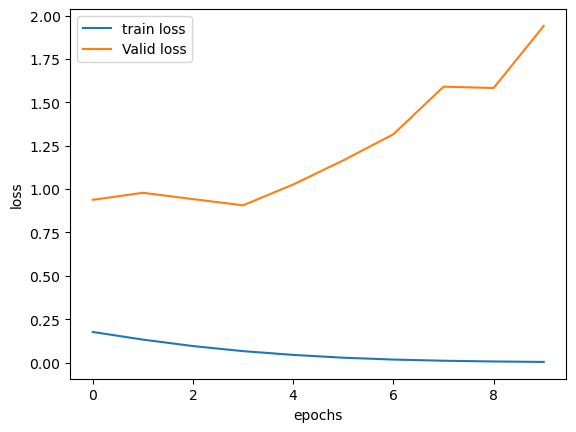

In [28]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss','Valid loss'])

# Model Evaluation

In [168]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def get_accuracy(preds, abstracts):
#     print("preds: ", preds.shape)
#     print("abstracts:", abstracts.shape)
pred_ids = preds.argmax(1)
correct_preds = (pred_ids == abstracts).sum().item()
# Calculate the total number of samples
total_samples = abstracts.shape[0] * abstracts.shape[1]

# Calculate accuracy as the ratio of correct predictions to total samples
accuracy = correct_preds / total_samples
return accuracy

In [69]:
test= torch.tensor([[1,2,4],[1,2,3]])
print(test.shape)
print(test[:-1, :])

torch.Size([2, 3])
tensor([[1, 2, 4]])


In [301]:
model.eval()
def decode(preds, abstracts):
    pred_ids = preds.argmax(1)
    for i in range(len(pred_ids)):
        sentence = ""
        sentence2 = ""
        for j in range(ABSTRACT_MAX):
            sentence += abstract_vocab.get_word(pred_ids[i][j].item()) + " "
            sentence2 += abstract_vocab.get_word(abstracts[i][j].item()) + " "
        print("pred: ",sentence)
        print("abstract: ",sentence2)
def get_accuracy2(preds, abstracts):
#     print("preds: ", preds.shape)
#     print("abstracts:", abstracts.shape)
    pred_ids = preds.argmax(1)

    correct_preds = (pred_ids == abstracts).sum().item()
    # Calculate the total number of samples
    total_samples = abstracts.shape[0] * abstracts.shape[1]
    
    # Calculate accuracy as the ratio of correct predictions to total samples
    accuracy = correct_preds / total_samples
    return accuracy
with torch.no_grad():
    for i, (abstract, text) in tqdm(enumerate(train_loader), total=len(train_loader)):

        text = text.to(device)
        abstract = abstract.to(device)
        # Encode the input sequence
        #encoder_output = model.EncoderNet(text)
        #print(encoder_output)
        # Initialize the initial prediction as the input sequence
        initial_prediction = torch.full((1,120), 0, device=device)
        initial_prediction[:,0]=1
        #print(abstract)
        #print(initial_prediction[:,:1])
        
        # Iterative refinement

#             print(text)
#             print(abstract)
        for i in range(1,120):
            outputs = model(text, abstract=initial_prediction[:,:i]).to(device).permute(1,2,0)
            #print("output",output.argmax(1))
            initial_prediction[:,i] = output.argmax(1)[0][i]
            
            #print(output.shape)
            # Apply temperature for sampling diversity
            #output = output #/ temperature
            # Apply softmax to get token probabilities
            #probs = nn.functional.softmax(output, dim=1)
            
            # Perform beam search or sampling
            # Greedy sampling (beam width of 1)
            
            #print(sampled_tokens.shape)
            # Update the initial prediction for the next iteration
            #initial_prediction = sampled_tokens
        decode(output, abstract)
    
        #print(get_accuracy2(initial_prediction, abstract))


  0%|          | 0/112 [00:00<?, ?it/s]

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> humans easily

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> report approa

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> relay channel

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> lately novel 

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> work gatys et

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> neural sequen

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> field artific

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> non local sel

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> semantic comp

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> paper extends

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> convolutional

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> study unsuper

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> recently deep

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> paper investi

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> recent introd

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> study propert

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> search engine

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> present datas

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> realistic ima

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> screening app

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> saliency dete

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> machine learn

pred:  neural neural networks networks effective models models variations variations modeling modeling models models models automatic generated asr asr hybrid speech recognition recognition cnns cnns hidden markov models mixture mixture mixture gmms gmms state state art art benchmarks models models news connections recurrent recurrent neural rnns rnns rnns sequences sequences feasible feasible train end end improved sequences hybrid hybrid settings rnns expensive expensive expensive train train inspired advantages hybrid ctc ctc end train end learning sequence sequence sequence combining combining hierarchical ctc recurrent recurrent recurrent evaluating approach train train train train train computationally computationally computationally competitive competitive improves dependency dependency capability capability points points correlations appropriate context <end> <end> <end> result result unlabeled datasets <end> <end> <end> <end> <end> <end> <end> 
abstract:  <start> having reliab

In [64]:
model.eval()

with torch.no_grad():
    for i, (abstract, text) in tqdm(enumerate(train_loader), total=len(test_loader)):
        print(model.EncoderNet(text.to(device)))
        outputs = torch.full((1,120), 1, device=device)
        outputs[:,0] = abstract[:,0]
        print(abstract_vocab.get_word(outputs[:,0].item()))
        print(abstract_vocab.get_word(abstract[:,1].item()))
        text = text.to(device)
        abstract = abstract.to(device)
        #print(outputs)
        for i in range(1, 120):
            print(outputs.shape)
            preds = model(text, outputs)
            #print("output", preds.shape)

            next_tokens = preds[:, -1, :].argmax(dim=-1).unsqueeze(1)
            print(next_tokens.shape)
#             for tok in next_tokens:
#                 print(abstract_vocab.get_word(tok.item()))
            #print("token",next_tokens)
            #print(next_tokens[i])
        
#             outputs[i] = next_tokens[i]
#             sentence = ""
#             sentence2 = ""
            outputs = torch.cat((outputs, next_tokens), dim=-1)
        
        for j in range(120):
              
            sentence += abstract_vocab.get_word(abstract[0][j].item()) + " "
            sentence2 += abstract_vocab.get_word(outputs[j].item()) + " "
        print("abs: ",sentence)
        print("")
        print("pred: ",sentence2)
        print("")
        break

  0%|          | 0/60 [00:00<?, ?it/s]

tensor([[[ 3.7763e-01,  1.7719e-01, -1.1044e-01,  ...,  1.2027e-01,
          -1.5995e+00,  3.2670e-01],
         [ 2.1302e-01,  4.1242e-01, -2.2151e-01,  ...,  3.7272e-01,
          -1.8935e+00,  3.5134e-01],
         [ 5.5395e-01,  2.1600e-01, -7.0079e-01,  ...,  3.0029e-01,
          -1.6553e+00,  4.9349e-01],
         ...,
         [ 4.9942e-01,  5.0533e-01, -4.5806e-01,  ..., -2.7786e-01,
          -2.0292e+00,  4.9953e-01],
         [-4.2056e-01,  4.2882e-01,  2.1639e-01,  ..., -1.9038e-02,
          -1.8020e+00,  3.4817e-01],
         [-2.6610e-01,  5.8974e-01,  2.4825e-01,  ...,  2.7032e-02,
          -1.9835e+00,  3.2657e-01]],

        [[ 1.6377e+00, -7.1653e-01,  1.4578e+00,  ...,  1.4358e-01,
          -1.7934e+00,  5.6160e-01],
         [ 1.4888e+00, -6.6770e-01,  1.3402e+00,  ...,  2.5333e-01,
          -2.2955e+00,  6.5187e-01],
         [ 1.9631e+00, -9.5902e-01,  6.4610e-01,  ...,  3.7765e-01,
          -1.8855e+00,  6.7810e-01],
         ...,
         [ 1.9492e+00, -6

RuntimeError: The expanded size of the tensor (1) must match the existing size (8) at non-singleton dimension 0.  Target sizes: [1].  Tensor sizes: [8]

In [ ]:
def decode(preds, abstracts):
    pred_ids = preds.argmax(1)
    for i in range(len(pred_ids)):
        sentence = ""
        sentence2 = ""
        for j in range(ABSTRACT_MAX):
            sentence += abstract_vocab.get_word(pred_ids[i][j].item()) + " "
            sentence2 += abstract_vocab.get_word(abstracts[i][j].item()) + " "
        print("pred: ",sentence)
        print("abstract: ",sentence2)

# FastText

## Model for querying

train fasttext model
obtain weight from fasttest
then embedding can load weights

- train 2 fasttext model, 1 for text and another for abstract
- obtain weights for both vocab
- put in encoder and decoder like normal
- https://stackoverflow.com/questions/31440803/how-to-fetch-vectors-for-a-word-list-with-word2vec
- use this to update the vocab class to update ways to fetch words
- to solve querying, use the model and use function to find cosine

In [6]:
import fasttext
model = fasttext.train_unsupervised('data/fil9')
model.save_model("result/fil9.bin")
model = fasttext.load_model("result/fil9.bin")
# EXPECTS TEXT FILE FORMAT WHERE 1 TEXT PER ROW
# IMPORTANT, NEED TO REDESIGN CLEANING PROCESS 

# Dataset Exploration

After exploring, all highlight:article ratio being more than 1.0 means the summary text is producing more text than the original text, this defeats the purpose of the model, therefore all data with a ratio of more than or equal to 1.0 will be omitted.

# Model improvement/Retrain

# Model Finalisation and Evaluation

In [29]:
import os
os.makedirs("my_model", exist_ok=True)

## Inference Script

In [ ]:
# Load model
best_model_path = "best_decoder20230719.pth"
best_model = Model(len(text_vocab),len(abstract_vocab),2,256)
best_model.load_state_dict(torch.load(best_model_path))